\<PAD\>: It represents padding and is used to make all sequences in a batch have the same length. Padding is required when the sequences in the batch have different lengths. This token is added to the end of shorter sequences until they match the length of the longest sequence in the batch.

\<UNK\>: It represents unknown words and is used when the model encounters words that are not in the vocabulary. This token helps to avoid out-of-vocabulary (OOV) errors and improves the performance of the model.

\<SOS\>: It represents start of sequence and is used as a special token at the beginning of a sequence. This token indicates the start of the sentence and helps the model to generate new sentences.

\<EOS\>: It represents end of sequence and is used as a special token at the end of a sequence. This token indicates the end of the sentence and helps the model to know when to stop generating new words.

## Data Preparation

In [1]:
import re, glob
from tqdm.auto import tqdm
from collections import Counter, OrderedDict

In [2]:
import torch
import torchtext

from torchtext.vocab import vocab
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import spacy

spacy.prefer_gpu()
# We use spaCy for preprocessing, but we only need the tokenizer and lemmatizer
# (for a large real-world dataset that would help with the performance)
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

import numpy as np
import pandas as pd

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# Custom BatchSampler
from src.sampler import EqualLengthsBatchSampler
from src.cnn_utils import Dict2Class, plot_training_results
from src.cnn import CnnSentenceClassifier, CnnTextClassifier

In [8]:
### read dataset

main_df = pd.read_csv("reddit_posts_proccessed.csv")
df = main_df.copy()
main_df.head()

,title,subreddit,body,problem
0,self help and self care resources,ptsd,unfortunately this is a small subreddit and as...,PTSD
1,survey thread,ptsd,if you have a survey you would like to share w...,PTSD
2,processing my trauma requires feeling safe but...,ptsd,and apparently i’m stuck in this loop because ...,PTSD
3,my sister is the strongest person i know. she’...,ptsd,"my sister has been bravely battling ptsd, bipo...",PTSD
4,has anyone else found mushrooms helped?,ptsd,at a point where i was immediately post assaul...,PTSD


In [9]:
# import os
# import sys
 
# # setting path
# sys.path.append(os.path.dirname(os.getcwd()))
 
# # importing
# from text_processing import text_processing

# clean_text = text_processing()
# clean_text.process_data(df, headers = ['title', 'subreddit', 'body'])

# from src.utils import text_normalization
# normalized_text = text_normalization()
# normalized_text.normalize_data(df)


In [10]:
def lemmatize(text):
    doc = nlp(text)
    
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    
    # ignoring the stopwords
    tokens = [ token for token in tokens if not token.is_stop]
     
    # Convert those tokens into lemmas, EXCEPT the pronouns
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas


# documents = df.body

# documents_lemmatized = [lemmatize(post) for post in documents]
# documents_lemmatized

In [11]:
token_counter = Counter()
problem_labels = []

for post,label in zip(df.body,df.problem):
    for token in lemmatize(post):
        token_counter[token] += 1            
        # Add label to targets list
        problem_labels.append(label)

In [12]:
index2label = { k:v for k, v in enumerate(set(problem_labels)) }
label2index = {v: k for k, v in index2label.items()}

target_vectors_problem_labels  = [ label2index[label] for label in problem_labels ]

#### Create Vocabulary

To create our `vocab` object, we perform exactly the same steps as above. The only difference is that our "full" vocabulary is not larger (although with less then 20k tokens still rather small). We therefore limit the vocabulary here to the 10,000 most frequent tokens.

In [13]:
# Sort by word frequency
token_counter_sorted = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)

print("Number of tokens: {}".format(len(token_counter_sorted)))

Number of tokens: 29671


In [14]:
TOP_TOKENS = 10000

token_counter_sorted = token_counter_sorted[:TOP_TOKENS]

print("Number of tokens: {}".format(len(token_counter_sorted)))

Number of tokens: 10000


In [15]:
token_ordered_dict = OrderedDict(token_counter_sorted)

# Define list of "special" tokens
SPECIALS = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

vocabulary = vocab(token_ordered_dict, specials=SPECIALS)

vocabulary.set_default_index(vocabulary["<UNK>"])

print("Number of tokens: {}".format(len(vocabulary)))

Number of tokens: 10004


### Save Dataset

Lastly, we save all the data for later use.

In [16]:
def preprocess(text):
    return [token.lemma_.lower() for token in nlp(text)]

In [17]:
output_file = open("data/problem-dataset-vectors-{}.txt".format(TOP_TOKENS), "w")

for i in range(df.shape[0]):
    post = df.body.iloc[i]
    label = label2index[df.problem.iloc[i]]
    vector = vocabulary.lookup_indices(preprocess(post))
    output_file.write("{}\t{}\n".format(" ".join([str(idx) for idx in vector]), label))
            
output_file.flush()
output_file.close()            

#### Save Metadata

In [18]:
vocabulary_file_name = "data/problem-corpus-{}.vocab".format(TOP_TOKENS)

torch.save(vocabulary, vocabulary_file_name)

In [19]:
label2index_file_name = "data/problem-label2index-{}.dict".format(TOP_TOKENS)
index2label_file_name = "data/problem-index2label-{}.dict".format(TOP_TOKENS)

torch.save(label2index, label2index_file_name)
torch.save(index2label, index2label_file_name)

## Load Dataset

In [20]:
vocabulary = torch.load("data/problem-corpus-10000.vocab")

vocab_size = len(vocabulary)

print("Size of vocabulary:\t{}".format(vocab_size))

Size of vocabulary:	10004


In [21]:
sequences, targets = [], []

with open("data/problem-dataset-vectors-10000.txt") as file:
    for line in file:
        line = line.strip()
        # The input sequences and class labels are separated by a tab
        sequence, label = line.split("\t")
        # Convert sequence string to a list of integers (reflecting the indicies in the vocabulary)
        sequence = [ int(idx) for idx in sequence.split()]
        # Convert each sequence into a tensor
        sequence = torch.LongTensor(sequence)
        # Add sequence and label to the respective lists
        sequences.append(sequence)
        targets.append(int(label))
        
# As targets is just a list of class labels, we can directly convert it into a tensor
targets = torch.LongTensor(targets)

In [22]:
# create training set
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.5, shuffle=True, random_state=0)

print("Number of training samples:\t{}".format(len(X_train)))
print("Number of test samples:\t\t{}".format(len(X_test)))

Number of training samples:	10590
Number of test samples:		10590


In [23]:
class BaseDataset(Dataset):

    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        if self.targets is None:
            return np.asarray(self.inputs[index])
        else:
            return np.asarray(self.inputs[index]), np.asarray(self.targets[index])

In [24]:
batch_size = 256

dataset_train = BaseDataset(X_train, y_train)
sampler_train = EqualLengthsBatchSampler(batch_size, X_train, y_train)
loader_train = DataLoader(dataset_train, batch_sampler=sampler_train, shuffle=False, drop_last=False)

dataset_test = BaseDataset(X_test, y_test)
sampler_test = EqualLengthsBatchSampler(batch_size, X_test, y_test)
loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)

## Train & Evaluate Model

### Auxiliary Methods

In [25]:
device = torch.device("cpu")

print("Available device: {}".format(device))

Available device: cpu


In [26]:
def evaluate(model, loader, fixed_seq_len=None, min_seq_len=None):
    
    y_true, y_pred = [], []
    
    with tqdm(total=len(loader)) as pbar:

        for X_batch, y_batch in loader:
            batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]
            
            if fixed_seq_len is not None:
                X_batch = create_fixed_length_batch(X_batch, fixed_seq_len)            
                
            if min_seq_len is not None:
                X_batch = torch.nn.functional.pad(X_batch, (0, min_seq_len-seq_len), mode="constant", value=0)         

            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            log_probs = model(X_batch)                

            y_batch_pred = torch.argmax(log_probs, dim=1)

            y_true += list(y_batch.cpu())
            y_pred += list(y_batch_pred.cpu())
            
            pbar.update(batch_size)

    return f1_score(y_true, y_pred,average="macro")

In [27]:
def train_epoch(model, loader, optimizer, criterion, fixed_seq_len=None, min_seq_len=None):
    
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0

    with tqdm(total=len(loader)) as pbar:

        for X_batch, y_batch in loader:
            batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]

            if fixed_seq_len is not None:
                X_batch = create_fixed_length_batch(X_batch, fixed_seq_len)            
                
            if min_seq_len is not None:
                X_batch = torch.nn.functional.pad(X_batch, (0, min_seq_len-seq_len), mode="constant", value=0)    
            
                
            # Move the batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            log_probs = model(X_batch)                

            # Calculate loss
            loss = criterion(log_probs, y_batch)
            
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of overall epoch loss
            epoch_loss += loss.item()

            pbar.update(batch_size)
            
    return epoch_loss

In [28]:
def train(model, loader_train, loader_test, optimizer, criterion, num_epochs, fixed_seq_len=None, min_seq_len=None, verbose=False):
    
    results = []
    
    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    for epoch in tqdm(range(1, num_epochs+1)):
        model.train()
        epoch_loss = train_epoch(model, loader_train, optimizer, criterion, fixed_seq_len=fixed_seq_len, min_seq_len=min_seq_len)
        model.eval()
        acc_train = evaluate(model, loader_train, fixed_seq_len=fixed_seq_len, min_seq_len=min_seq_len)
        acc_test = evaluate(model, loader_test, fixed_seq_len=fixed_seq_len, min_seq_len=min_seq_len)

        results.append((epoch_loss, acc_train, acc_test))
        
        if verbose is True:
            print("[Epoch {}] loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} ".format(epoch, epoch_loss, acc_train, acc_test))
            
    return results

In [29]:
# Create model   
cnn = CnnSentenceClassifier(vocab_size, 8, 100).to(device)
# Define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
# Define loss function
criterion = nn.NLLLoss()

print(cnn)

CnnSentenceClassifier(
  (embedding): Embedding(10004, 100)
  (conv2): Conv2d(1, 2, kernel_size=(2, 100), stride=(1, 1))
  (conv3): Conv2d(1, 2, kernel_size=(3, 100), stride=(1, 1))
  (conv4): Conv2d(1, 2, kernel_size=(4, 100), stride=(1, 1))
  (out): Linear(in_features=6, out_features=8, bias=True)
)


In [30]:
evaluate(cnn, loader_test, min_seq_len=4)

  0%|          | 0/10590 [00:00<?, ?it/s]

0.032203746197243074

In [31]:
num_epochs = 20

#train(basic_rnn_classifier, loader, num_epochs, verbose=True)
results = train(cnn, loader_train, loader_test, optimizer, criterion, num_epochs, min_seq_len=4, verbose=True)

Total Training Time (total number of epochs: 20)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 1] loss:	1722.236, f1 train: 0.108, f1 test: 0.089 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 2] loss:	1647.061, f1 train: 0.123, f1 test: 0.101 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 3] loss:	1556.453, f1 train: 0.197, f1 test: 0.125 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 4] loss:	1432.120, f1 train: 0.262, f1 test: 0.159 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 5] loss:	1356.961, f1 train: 0.297, f1 test: 0.174 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 6] loss:	1271.085, f1 train: 0.301, f1 test: 0.166 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 7] loss:	1237.634, f1 train: 0.322, f1 test: 0.167 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 8] loss:	1190.318, f1 train: 0.311, f1 test: 0.155 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 9] loss:	1163.965, f1 train: 0.322, f1 test: 0.153 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 10] loss:	1152.157, f1 train: 0.339, f1 test: 0.161 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 11] loss:	1136.637, f1 train: 0.405, f1 test: 0.181 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 12] loss:	1116.894, f1 train: 0.404, f1 test: 0.180 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 13] loss:	1111.914, f1 train: 0.386, f1 test: 0.173 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 14] loss:	1091.349, f1 train: 0.380, f1 test: 0.171 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 15] loss:	1108.046, f1 train: 0.416, f1 test: 0.188 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 16] loss:	1084.221, f1 train: 0.423, f1 test: 0.183 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 17] loss:	1075.596, f1 train: 0.425, f1 test: 0.187 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 18] loss:	1079.029, f1 train: 0.396, f1 test: 0.179 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 19] loss:	1078.454, f1 train: 0.409, f1 test: 0.177 


  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

  0%|          | 0/10590 [00:00<?, ?it/s]

[Epoch 20] loss:	1072.539, f1 train: 0.418, f1 test: 0.187 


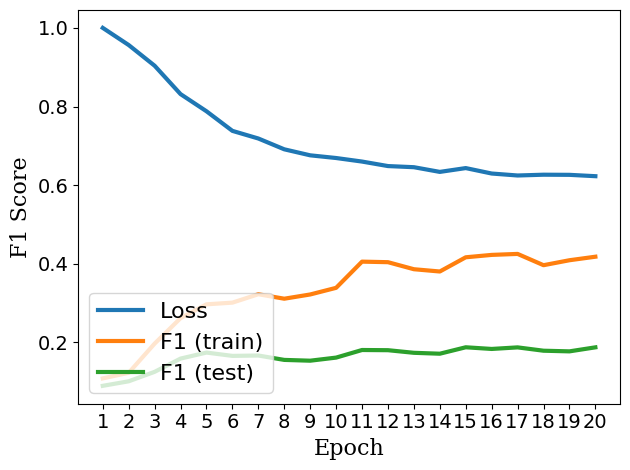

In [32]:
plot_training_results(results)